## Exteval Modified Corrector Research

This notebooks contains my research regarding the EXTEVAL-Modified-Metric.
The metric was modified to output more information of the detected errors.

### Step 1: Run ExtEval-Modified on the summaries to see the exact scores it predicts for `data_only_incorrect.json` witd extended information for the found errors

These scores will be saved in `data_only_incorrect_exteval_modified.json` and are needed for the prompt to `GPT-4o` and later for the `Evaluation`.
The new exteval modified will provide a lot more information for `GPT-4o mini` and will ensure a better correction later.

(The `data_only_incorrect.json` was already created by `Step 1` of the `exteval-corrector-research`)

In [1]:
import subprocess

# Define the command and its arguments
command = [
    "python3",
    "exteval/extevalModified.py",
    "--data_file", "data/data_only_incorrect.json",
    "--output_file", "data/scores/data_only_incorrect_exteval_modified.json"
]

# Execute the command
result = subprocess.run(command, capture_output=True, text=True)

# Print the output and errors
if result.returncode == 0:
    print("Command executed successfully.")
    print(result.stdout)
else:
    print("Error occurred while executing the command.")
    print(result.stderr)


Command executed successfully.
837.0383448600769



### Step 2: Combine incorrect data (`data_only_incorrect.json`) with their exteval scores (`data_only_incorrect_exteval_modified.json`) -> Prepartion for easy access in the prompt

The new merged data will be saved in `data_incorrect_merged_modified.json` and will be used for the prompt to `GPT-4o` in the next step.

In [2]:
import json

raw_data = "data/data_only_incorrect.json"
exteval_modified_data = "data/scores/data_only_incorrect_exteval_modified.json"
output_path = "data/merged/data_only_incorrect_merged_modified.json"

# read_data
with open(raw_data, 'r', encoding='utf-8') as f1:
    data1 = json.load(f1)

with open(exteval_modified_data, 'r', encoding='utf-8') as f2:
    data2 = json.load(f2)

# result dictionary for the new json
merged_data = {}

# Merging of the data
for key, value2 in data2.items():
    if key in data1:  # check if the key is in both files
        value1 = data1[key]
        
        # create new structure
        merged_entry = {
            **value2, # gets all fields from the second json
            "summary": value1.get("summary"),
            "document": value1.get("document"),
            "summary_for_annotation": value1.get("summary_for_annotation"),
            "document_for_annotation": value1.get("document_for_annotation")
        }
        
        # save inside new json
        merged_data[key] = merged_entry

# save completed new json
with open(output_path, 'w', encoding='utf-8') as output_file:
    json.dump(merged_data, output_file, ensure_ascii=False, indent=4)

print(f"Merged JSON saved to {output_path}")


Merged JSON saved to data/merged/data_only_incorrect_merged_modified.json


### Step 3: Call `GPT-4o` for every entry inside the `data_only_incorrect_merged_modified.json` file with the prompt mask with more information from ExtEval-Modified

For every entry (484 entries) a call to `GPT-4o` will be made to get a new extractive summary which will be saved in a new file called `data_new.json`.

In [7]:
from openai import OpenAI
import json
import re

client = OpenAI(api_key="<your_api_key>")

# Create the prompt
prompt = """
You are an expert AI assistant specializing in extractive summarization and evaluation using an advanced EXTEVAL framework. EXTEVAL assesses extractive summaries' faithfulness using the following error categories and metrics:

### EXTEVAL Metrics
1. **Incorrect Coreference (INCORCOREFEVAL):**
   - **Definition:** Refers to incorrect mapping of pronouns or noun phrases to their antecedents.
   - **Details Provided:** Count and list of specific instances, including:
     - Problematic sentence(s)
     - Specific mention(s)
     - Error type (e.g., "ambiguous pronoun").

2. **Incomplete Coreference (INCOMCOREFEVAL):**
   - **Definition:** Indicates missing or unclear antecedents for references in the text.
   - **Details Provided:** Count and list of specific instances, including:
     - Problematic sentence(s)
     - Specific mention(s)
     - Error type (e.g., "missing antecedent").

3. **Incorrect Discourse (INCOMDISCOEVAL):**
   - **Definition:** Highlights faulty or misleading discourse relationships, such as inappropriate use of conjunctions or connectors.
   - **Details Provided:** Count and list of specific instances, including:
     - Problematic sentence(s)
     - Specific discourse marker(s).

4. **Sentiment Bias (SENTIBIAS):**
   - **Definition:** Measures misalignment of sentiments between the source document and the summary.
   - **Details Provided:**
     - Absolute difference between document and summary sentiment.
     - Average sentiment of the source document and summary.
     - List of significant deviations with:
       - Problematic sentence(s)
       - Document sentiment
       - Summary sentiment.

5. **Overall EXTEVAL Score (EXTEVAL):**
   - Represents a weighted aggregation of all sub-metrics, with higher values indicating greater issues.

### Task
I will provide:
- The **original document**.
- The **extractive summary**.
- Detailed EXTEVAL scores with specific error details.

Your responsibilities:
1. **Analyze** the provided EXTEVAL scores and error details to identify the problematic areas in the summary.
2. **Revise** the summary to address the identified issues, ensuring it is faithful, coherent, and sentimentally aligned with the source document.

### Response Format
Respond in this JSON format:
```json
{{
    "corrected_extractive_summary": "<your revised summary>",
    "justifications": {{
        "IncorCorefEval": "<summary of changes made>",
        "IncomCorefEval": "<summary of changes made>",
        "IncomDiscoEval": "<summary of changes made>",
        "SentiBias": "<summary of changes made>"
    }}
}}
```

### Inputs
Here is the original document: {original_text}
Here is the extractive summary: {extractive_summary}
Here are the EXTEVAL scores: {exteval_scores}

### Notes
For Incorrect Coreference and Incomplete Coreference, revise pronouns or noun phrases to ensure accurate and clear references.
For Incorrect Discourse, restructure sentences or replace discourse markers to create logical and coherent relationships.
For Sentiment Bias, adjust phrasing or tone to align the summary's sentiment with the source document's sentiment distribution. """

def load_json(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return json.load(file)

def save_json(data, file_path):
    with open(file_path, 'w', encoding='utf-8') as file:
        json.dump(data, file, ensure_ascii=False, indent=4)


# function for the prompts
def generate_prompts_and_save(input_file, output_file):
    data = load_json(input_file)
    output_data = {}

    for key, entry in data.items():
        document = entry.get("document", "")
        summary = entry.get("summary", "")
        exteval_scores = {
            "IncorCorefEval": entry.get("IncorCorefEval", ""),
            "IncomCorefEval": entry.get("IncomCorefEval", ""),
            "IncomDiscoEval": entry.get("IncomDiscoEval", ""),
            "SentiBias": entry.get("SentiBias", ""),
            "ExtEval": entry.get("ExtEval", ""),
        }
        
        try:
            # api call
            response = client.chat.completions.create(
                model="gpt-4o",
                messages=[
                    {"role": "system", "content": "You are a highly knowledgeable assistant trained in extractive summarization and evaluation."},
                    {"role": "user", "content": prompt.format(
                        original_text=document,
                        extractive_summary=summary,
                        exteval_scores=exteval_scores
                    )}
                ]
            )

            # access the answer
            response_text = response.choices[0].message.content

            #extract only the json part from the answer
            json_match = re.search(r"{.*}", response_text, re.DOTALL)
            if json_match:
                json_text = json_match.group(0)
                try:
                    response_json = json.loads(json_text) 
                    corrected_extractive_summary = response_json.get("corrected_extractive_summary", None)
                    justifications = response_json.get("justifications", None)
                except json.JSONDecodeError as e:
                    print(f"JSONDecodeError for {key}: {e}")
                    print(f"Response Text: {response_text}")
                    corrected_extractive_summary = None
                    justifications = None
            else:
                print(f"No valid JSON found in response for {key}. Response Text: {response_text}")
                corrected_extractive_summary = None
                justifications = None

            # save the results
            output_data[key] = {
                "document": document,
                "corrected_extractive_summary": corrected_extractive_summary,
                "justifications": justifications
            }
        except Exception as e:
            print(f"Error while trying to get a response from GPT-4 {key}: {e}")
            output_data[key] = {
                "document": document,
                "response": f"Error: {e}"
            }

    # save all results to a json
    save_json(output_data, output_file)
    print(f"Results were saved to: {output_file}.")


# Call
input_file_path = "data/merged/data_only_incorrect_merged_modified.json"
output_file_path = "data/corrected/corrected_data_modified.json"
generate_prompts_and_save(input_file_path, output_file_path)

JSONDecodeError for 207_textrank_st: Expecting ',' delimiter: line 6 column 138 (char 849)
Response Text: ```json
{
    "corrected_extractive_summary": "<t> The family respectfully requested that people do not vote for Hillary Clinton in 2016, as stated in Larry Upright's obituary. </t> <t> Marina Shear of Dallas wrote in the online guestbook, 'You have my solemn promise I will not waste a vote on Hillary Clinton.'</t>",
    "justifications": {
        "IncorCorefEval": "No instances of incorrect coreference needed addressing.",
        "IncomCorefEval": "Clarified 'the family' in the first summary sentence by specifying 'The family of Larry Upright' to provide context. Clarified 'the obituary's' in the second summary sentence by explicitly mentioning 'Larry Upright's obituary' to address incomplete antecedents.",
        "IncomDiscoEval": "Removed the discourse marker 'also' and rewrote the sentence to eliminate the misleading progression implied."),
        "SentiBias": "Adjusted the

### Key Points from the prompt:

1. **Enhanced EXTEVAL Details**: Incorporated the extended EXTEVAL scores with **count, details, sentiment deviations**, and metrics for better analysis.
2. **Actionable Justifications**: Added more context in the "justifications" section for each metric.
3. **Clarity in Sentiment Bias**: Highlighted specific sentences with sentiment deviations, providing sentence-level sentiment values to aid targeted corrections.
4. **Structured Error Insights**: Explicitly included `summary_sentence`, `mention`, `type`, and `discourse_marker` in the task instructions, helping the AI pinpoint corrections.

This refined prompt ensures detailed insights for correction while leveraging all the nuances in the new EXTEVAL data structure.

### Error Handling

The prompting to `GPT-4o` throwed one error. For this one error the prompt was manually created and given to `GPT-4o` to correct. The response was inserted into the `corrected_data_modified.json`.

### Step 4: Now the new and corrected summaries are evaluated by ExtEval Modified to get new scores (for the summaries that were corrected with the extra information from ExtEval Modified)

For this the new summaries need to be processed (`preprocess.py`) and after that evaluated (`exteval_modified.py`). The new scores for the corrected summaries will be saved to `data_new_exteval_modified.json`.

In [1]:
import subprocess

# Define the input and output files
data_file = "data/corrected/corrected_data_modified.json"
output_file = "data/corrected/preprocessed/corrected_data_preprocessed_modified.json"

# Build and execute the command
command = ["python", "exteval/preprocessForCorrected.py", "--data_file", data_file, "--output_file", output_file]

try:
    result = subprocess.run(command, check=True, text=True, capture_output=True)
    print("Script executed successfully:")
    print(result.stdout)
except subprocess.CalledProcessError as e:
    print("Error while executing the script:")
    print(e.stderr)


Script executed successfully:
1734.7294573783875



In [2]:
import subprocess

# Define the input and output files
data_file = "data/corrected/preprocessed/corrected_data_preprocessed_modified.json"
output_file = "data/corrected/scores/corrected_data_exteval_modified.json"

# Build and execute the command
command = ["python", "exteval/extevalModifiedForCorrected.py", "--data_file", data_file, "--output_file", output_file]

try:
    result = subprocess.run(command, check=True, text=True, capture_output=True)
    print("Script executed successfully:")
    print(result.stdout)
except subprocess.CalledProcessError as e:
    print("Error while executing the script:")
    print(e.stderr)


Script executed successfully:
814.2970662117004



### Step 6: The new ExtEval-Modified scores are now compared to the old ones to see the improvement 

In [7]:
import os
import json
import pandas as pd
from IPython.display import display

# Define the list of relevant metrics
metrics_of_interest = [
    "IncorCorefEval",
    "IncomCorefEval",
    "IncomDiscoEval",
    "SentiBias",
    "ExtEval"
]

# Load the JSON files
file1 = "data/scores/data_only_incorrect_exteval_modified.json"  # Replace with the actual file name
file2 = "data/corrected/scores/corrected_data_exteval_modified.json"

with open(file1, "r") as f1, open(file2, "r") as f2:
    data1 = json.load(f1)
    data2 = json.load(f2)

# Create a DataFrame to store the comparison
comparison_data = []

# Compare the metrics for each object
total_improvements = {metric: 0 for metric in metrics_of_interest}
valid_counts = {metric: 0 for metric in metrics_of_interest}

def extract_value(metric, data):
    """Extract the relevant value based on the metric's structure."""
    if metric in data:
        if isinstance(data[metric], dict):
            # Handle nested structures
            if "absolute_difference" in data[metric]:  # For SentiBias
                return data[metric]["absolute_difference"]
            elif "count" in data[metric]:  # For metrics with a count
                return data[metric]["count"]
        else:
            return data[metric]
    return None

for key in data1.keys():
    if key in data2:
        comparison = {"Object": key}
        for metric in metrics_of_interest:
            score1 = extract_value(metric, data1[key])  # Extract value for file1
            score2 = extract_value(metric, data2[key])  # Extract value for file2
            if score1 is not None and score2 is not None:  # Only compare if both values are present
                improvement = score1 - score2  # Improvement: positive means score2 is better
                percentage_improvement = (improvement / score1 * 100) if score1 != 0 else None
                comparison[f"{metric}_file1"] = score1
                comparison[f"{metric}_file2"] = score2
                comparison[f"{metric}_improvement"] = improvement
                comparison[f"{metric}_percentage_improvement"] = percentage_improvement
                if percentage_improvement is not None:
                    total_improvements[metric] += percentage_improvement
                    valid_counts[metric] += 1
        comparison_data.append(comparison)

# Calculate overall percentage improvements
overall_percentage_improvements = {
    metric: (total_improvements[metric] / valid_counts[metric]) if valid_counts[metric] > 0 else None
    for metric in metrics_of_interest
}

# Convert to a DataFrame for easier analysis
df = pd.DataFrame(comparison_data)

# Add overall percentage improvements as a summary
overall_summary = {"Object": "Overall Average"}
for metric in metrics_of_interest:
    overall_summary[f"{metric}_percentage_improvement"] = overall_percentage_improvements.get(metric, None)

# Use pd.concat() instead of .append()
summary_df = pd.DataFrame([overall_summary])
df = pd.concat([df, summary_df], ignore_index=True)

# Ensure the results directory exists
results_dir = "results"
os.makedirs(results_dir, exist_ok=True)

# Save the comparison to the `results/` directory
output_file = os.path.join(results_dir, "percentage_improvement_comparison_modified.csv")
df.to_csv(output_file, index=False)

# Display the DataFrame directly in the notebook
display(df)

print(f"Percentage improvement comparison saved to {output_file}.")


,Object,IncorCorefEval_file1,IncorCorefEval_file2,IncorCorefEval_improvement,IncorCorefEval_percentage_improvement,IncomCorefEval_file1,IncomCorefEval_file2,IncomCorefEval_improvement,IncomCorefEval_percentage_improvement,IncomDiscoEval_file1,...,IncomDiscoEval_improvement,IncomDiscoEval_percentage_improvement,SentiBias_file1,SentiBias_file2,SentiBias_improvement,SentiBias_percentage_improvement,ExtEval_file1,ExtEval_file2,ExtEval_improvement,ExtEval_percentage_improvement
0,0_oracle_disco,0.0,0.0,0.0,NaN,1.0,0.0,1.0,100.000000,1.0,...,1.0,100.000000,0.001826,0.265880,-0.264054,-14463.607373,2.001826,0.265880,1.735946,86.718145
1,0_refresh,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,...,0.0,NaN,0.131254,0.040341,0.090913,69.265009,0.131254,0.040341,0.090913,69.265009
2,0_textrank,0.0,0.0,0.0,NaN,3.0,0.0,3.0,100.000000,2.0,...,2.0,100.000000,0.019680,0.128337,-0.108657,-552.118860,2.019680,0.128337,1.891343,93.645653
3,1_banditsumm,0.0,0.0,0.0,NaN,1.0,0.0,1.0,100.000000,0.0,...,0.0,NaN,0.020202,0.143446,-0.123243,-610.050589,1.020202,0.143446,0.876757,85.939497
4,1_heter_graph,0.0,0.0,0.0,NaN,1.0,0.0,1.0,100.000000,0.0,...,0.0,NaN,0.052363,0.019570,0.032793,62.626461,1.052363,0.019570,1.032793,98.140380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
480,64_histruct,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,1.0,...,1.0,100.000000,0.421352,0.089865,0.331486,78.672127,1.421352,0.089865,1.331486,93.677472
481,79_histruct,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,1.0,...,1.0,100.000000,0.093155,0.098390,-0.005235,-5.619822,1.093155,0.098390,0.994765,90.999410
482,82_histruct,0.0,0.0,0.0,NaN,3.0,0.0,3.0,100.000000,0.0,...,0.0,NaN,0.204382,0.001112,0.203270,99.455815,1.204382,0.001112,1.203270,99.907653
483,93_histruct,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,...,0.0,NaN,0.054895,0.092941,-0.038046,-69.306525,0.054895,0.092941,-0.038046,-69.306525


Percentage improvement comparison saved to results/percentage_improvement_comparison_modified.csv.


In [6]:
data = df
# Calculate overall mean improvements
overall_mean_improvements = data.filter(like="_percentage_improvement").mean()

# Calculate overall median improvements
overall_median_improvements = data.filter(like="_percentage_improvement").median()

# Combine results into a new DataFrame
summary_stats = pd.DataFrame({
    "Metric": overall_mean_improvements.index.str.replace("_percentage_improvement", ""),
    "Mean_Percentage_Improvement": overall_mean_improvements.values,
    "Median_Percentage_Improvement": overall_median_improvements.values
})

# Display the summary statistics
summary_stats_display = summary_stats.round(2)
display(summary_stats_display)

# Save the summary as a CSV for further review
summary_file = "results/summary_statistics_modified.csv"
summary_stats.to_csv(summary_file, index=False)

print(f"Summary statistics saved to {summary_file}.")


,Metric,Mean_Percentage_Improvement,Median_Percentage_Improvement
0,IncorCorefEval,98.31,100.00
1,IncomCorefEval,87.91,100.00
2,IncomDiscoEval,85.82,100.00
3,SentiBias,-216.46,-0.72
4,ExtEval,-7.43,80.47


Summary statistics saved to results/summary_statistics_modified.csv.


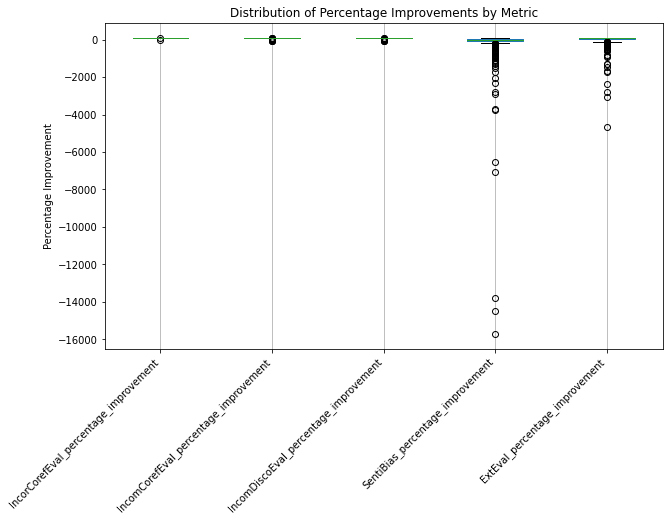

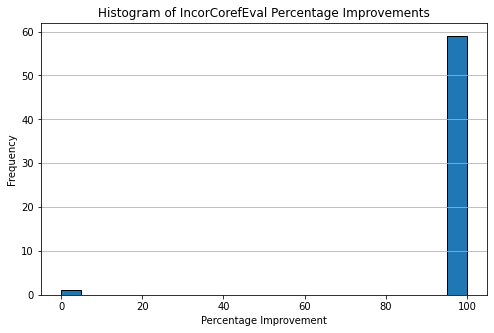

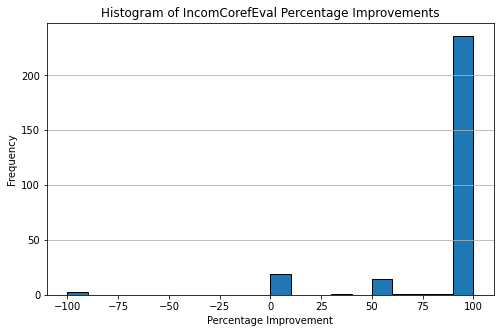

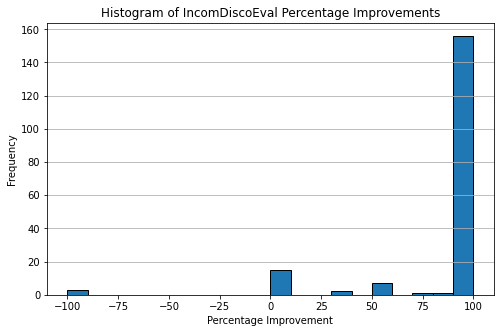

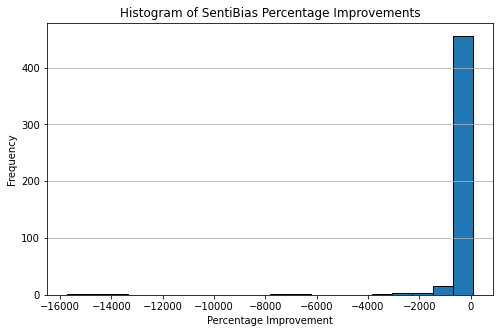

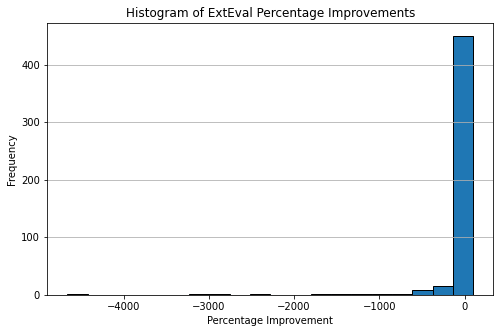

In [4]:
import matplotlib.pyplot as plt

# Filter percentage improvement columns
percentage_improvement_columns = data.filter(like="_percentage_improvement")

# Create Boxplot for Percentage Improvements
plt.figure(figsize=(10, 6))
percentage_improvement_columns.boxplot()
plt.title("Distribution of Percentage Improvements by Metric")
plt.ylabel("Percentage Improvement")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.show()

# Create Histogram for Each Metric's Percentage Improvement
for column in percentage_improvement_columns.columns:
    plt.figure(figsize=(8, 5))
    plt.hist(percentage_improvement_columns[column].dropna(), bins=20, edgecolor='black')
    plt.title(f"Histogram of {column.replace('_percentage_improvement', '')} Percentage Improvements")
    plt.xlabel("Percentage Improvement")
    plt.ylabel("Frequency")
    plt.grid(axis='y')
    plt.show()
